In [ ]:
!pip install --upgrade git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install -U sentence-transformers
!pip install "huggingface_hub==0.23.5"


In [ ]:
!pip install -q sentence-transformers xgboost


# API's FILES: TRAIN AND TEST

In [3]:
# Import libraries

import requests
import pandas as pd
import time

In [ ]:

# === CONFIGURATION ===
BASE_URL = "https://api.hackupm2025.workers.dev"
DELAY = 0.2
OUTPUT_FILE = "diabetes_train_data.csv"
HEADERS = {"Accept": "application/json"}


def fetch_all_data(BASE_URL, ENDPOINT, DELAY = 0.2, HEADERS = {"Accept": "application/json"}):
    """Fetch all training (has_diabetes=1) patient data across pages."""
    all_records = []
    page = 1

    print("Fetching data from Diabetes Patient Data API...")
    while True:
        params = {"page": page, "limit": 100}
        url = f"{BASE_URL}{ENDPOINT}"

        try:
            response = requests.get(url, headers=HEADERS, params=params, timeout=15)
        except requests.exceptions.RequestException as e:
            print(f"Network error: {e}")
            break

        if response.status_code != 200:
            print(f"HTTP Error {response.status_code}: {response.text[:200]}")
            break

        try:
            data = response.json()
        except ValueError:
            print("Invalid JSON response.")
            break

        # Extract patient records from common keys
        records = (
            data.get("items")
            or data.get("results")
            or data.get("data")
            or data.get("patients")
            or (data if isinstance(data, list) else [])
        )

        if not records:
            print(f"No more records found at page {page}.")
            break

        all_records.extend(records)
        print(f"Page {page}: got {len(records)} records (total: {len(all_records)})")

        page += 1
        time.sleep(DELAY)

    return all_records


def save_to_csv(data, output_path):
    """Save list of dictionaries to a CSV file."""
    if not data:
        print("No data to save.")
        return

    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    print(f"\nSaved {len(df)} records to '{output_path}'")
    print("\nPreview of the first 5 rows:\n")
    print(df.head())
    return df  # return df so we can use it later if needed


# === RUN ===
# TRAIN DATA
ENDPOINT = "/api/v1/patients/train"
data = fetch_all_data(BASE_URL, ENDPOINT)

# Save CSV to Kaggle working directory for download
kaggle_output_path = "/kaggle/working/diabetes_train_data.csv"
df = save_to_csv(data, kaggle_output_path)

# TEST DATA
ENDPOINT = "/api/v1/patients/test"
data = fetch_all_data(BASE_URL, ENDPOINT)

# Save CSV to Kaggle working directory for download
kaggle_output_path = "/kaggle/working/diabetes_test_data.csv"
df = save_to_csv(data, kaggle_output_path)

print("\nDone! You can download the CSV from the right panel under 'Output'.")


In [4]:
# Delete the numerical values of ID

# Load your CSV
df = pd.read_csv("/kaggle/working/diabetes_train_data.csv")

# Example: assume 'medical_note' column contains text
texts = df['medical_note'].astype(str).tolist()

# MAIN PIPELINE TRAINING

## 1. Import libraries

In [6]:
# ====================================================
# Libraries & Configuration
# ====================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# Optional: show progress for SentenceTransformer
print("All libraries imported successfully.")



All libraries imported successfully.


## 2. Split train/test data

In [7]:
# ====================================================
# Load and Split Data (90% train / 10% validation)
# ====================================================
df = pd.read_csv("/kaggle/working/diabetes_train_data.csv")

# Check columns
assert 'medical_note' in df.columns, "Column 'medical_note' missing."
assert 'has_diabetes' in df.columns, "Column 'has_diabetes' missing."

# Split the dataset
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['has_diabetes']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Optional save
train_df.to_csv("/kaggle/working/train_internal.csv", index=False)
val_df.to_csv("/kaggle/working/val_internal.csv", index=False)


✅ Training samples: 2700
✅ Validation samples: 300


Usually, the ratio between training data and alidation data is 80/20. However, we have chosen to split the data in 90% training and 10% to validate them.

## 3. load model

In [83]:
# ====================================================
# Load multilingual biomedical text encoder
# ====================================================
from sentence_transformers import SentenceTransformer

# Model choice: multilingual + biomedical capable
model_name = "intfloat/multilingual-e5-large"
model = SentenceTransformer(model_name)

print(f"Loaded model: {model_name}")


Loaded model: intfloat/multilingual-e5-large


## 4. Encode into embeddings

In [69]:
# ====================================================
# Encode medical notes into embeddings
# ====================================================
# Convert text to string and encode
train_embeddings = model.encode(
    train_df['medical_note'].astype(str).tolist(),
    batch_size=16,
    show_progress_bar=True,
    device='cuda'
)

val_embeddings = model.encode(
    val_df['medical_note'].astype(str).tolist(),
    batch_size=16,
    show_progress_bar=True,
    device='cuda'
)

# Prepare labels
y_train = train_df['has_diabetes'].values
y_val = val_df['has_diabetes'].values

print("Embeddings generated.")
print("Train shape:", train_embeddings.shape)
print("Val shape:", val_embeddings.shape)


Batches:   0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

✅ Embeddings generated.
Train shape: (2700, 512)
Val shape: (300, 512)


> What are emdeddings? Embeddings in AI are numerical representations (vectors) of real-world objects like text, images, or audio that capture their meaning and relationships> 

## 5. Train the model

In [29]:
# ====================================================
# Train XGBoost model
# ====================================================
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=1,
    random_state=42,
    n_jobs=-1
)

xgb.fit(train_embeddings, y_train)
print("XGBoost training complete.")


✅ XGBoost training complete.


## 6. Evaluate the model

In [30]:
# ====================================================
# Evaluate model performance
# ====================================================
y_pred = xgb.predict(val_embeddings)

f1 = f1_score(y_val, y_pred)
print(f"\n F1 Score: {f1:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_val, y_pred))



🎯 F1 Score: 0.7219

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       210
           1       0.77      0.68      0.72        90

    accuracy                           0.84       300
   macro avg       0.82      0.80      0.81       300
weighted avg       0.84      0.84      0.84       300



## 7. Save predictions

In [16]:
# ====================================================
# Save model and predictions
# ====================================================
import joblib

joblib.dump(xgb, "/kaggle/working/xgb_mednlp_model.joblib")

preds_df = pd.DataFrame({
    "text": val_df["medical_note"],
    "true_label": y_val,
    "predicted_label": y_pred
})
preds_df.to_csv("/kaggle/working/validation_predictions.csv", index=False)

print("Model and predictions saved to Kaggle working directory.")


✅ Model and predictions saved to Kaggle working directory.


# HYPERTUNING

Not necessary to the analysis, it is optional

In [18]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [200, 400, 500],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 0.9]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(train_embeddings, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)
print("Best F1 (CV):", grid_search.best_score_)



Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Best Hyperparameters:
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.8}
Best F1 (CV): 0.727931544044319


# FEATURE ENGINEERING

## 8. Enhance with feature engineering

In [84]:
# ====================================================
# Feature Engineering from Medical Notes
# ====================================================
import re

def extract_medical_features(text):
    text = text.lower()

   # --- Keyword flags ---
    diabetes_kw = int(any(word in text for word in [
        # English
        "diabetes", "dm", "t2dm", "type 2 diabetes",
        # French
        "diabète", "diabete",
        # Italian
        "diabete mellito", "diabete tipo 2",
        # German
        "zuckerkrankheit", "typ-2-diabetes", "typ2diabetes",
        # Portuguese
        "diabetes mellitus", "diabético", "diabete tipo 2"
    ]))
    
    insulin_kw = int(any(word in text for word in [
        "insulin", "insulina", "insuline", "insulinae", "insulintherapie"
    ]))

    hta_kw = int(any(word in text for word in [
    # English
    "hypertension", "high blood pressure", "hbp",
    # French
    "hypertension artérielle", "hta",
    # Italian
    "ipertensione", "pressione alta",
    # German
    "bluthochdruck", "hypertonie",
    # Portuguese
    "hipertensão", "pressão alta"
    ]))

    obesity_kw = int(any(word in text for word in [
        # English
        "obesity", "obese", "overweight",
        # French
        "obésité", "en surpoids",
        # Italian
        "obesità", "sovrappeso",
        # German
        "fettleibigkeit", "übergewicht",
        # Portuguese
        "obesidade", "sobrepeso"
    ]))

    # --- Negations (e.g., "no diabetes") ---
    neg_kw = int(any(word in text for word in [
        # English
        "no ", "without ", "denies ",
        # French
        "pas de ", "sans ", "aucun signe de ",
        # Italian
        "non ", "senza ", "assenza di ",
        # German
        "kein ", "ohne ", "nicht vorhanden ",
        # Portuguese
        "sem ", "nega ", "ausência de "
    ]))

    # --- Numeric features (lab values) ---
    glucose_match = re.search(r"glucosa[:=]?\s*(\d+\.?\d*)", text)
    hba1c_match = re.search(r"hba1c[:=]?\s*(\d+\.?\d*)", text)

  # --- Numeric features (lab values) ---
    glucose_match = re.search(r"(glucose|glucosa|glycémie|glicemia|zucker)[:=]?\s*(\d+\.?\d*)", text)
    hba1c_match = re.search(r"(hba1c|hemoglobina glicada|hémoglobine glyquée|glycohämoglobin)[:=]?\s*(\d+\.?\d*)", text)

    glucose = float(glucose_match.group(2)) if glucose_match else np.nan
    hba1c = float(hba1c_match.group(2)) if hba1c_match else np.nan

    # --- Meta features ---
    num_words = len(text.split())
    num_numbers = len(re.findall(r'\d+', text))

    return pd.Series({
        "kw_diabetes": diabetes_kw,
        "kw_insulin": insulin_kw,
        "kw_hypertension": hta_kw,
        "kw_obesity": obesity_kw,
        "kw_negation": neg_kw,
        "glucose": glucose,
        "hba1c": hba1c,
        "n_words": num_words,
        "n_numbers": num_numbers
    })

# Apply to both training and validation sets
train_feats = train_df['medical_note'].astype(str).apply(extract_medical_features)
val_feats = val_df['medical_note'].astype(str).apply(extract_medical_features)

print("Feature engineering completed.")
print(train_feats.head())


Feature engineering completed.
      kw_diabetes  kw_insulin  kw_hypertension  kw_obesity  kw_negation  \
2399          0.0         0.0              1.0         0.0          1.0   
2826          0.0         0.0              1.0         0.0          1.0   
2054          0.0         0.0              1.0         1.0          1.0   
99            0.0         0.0              1.0         1.0          1.0   
139           0.0         0.0              1.0         0.0          1.0   

      glucose  hba1c  n_words  n_numbers  
2399      NaN    NaN     87.0        6.0  
2826      NaN    NaN     88.0        6.0  
2054      NaN    NaN    111.0        6.0  
99        NaN    NaN     76.0        5.0  
139       NaN    NaN     85.0        3.0  


## 9. Combine embeddings with the features

In [85]:
# ====================================================
# Combine Embeddings + Engineered Features
# ====================================================
train_extra = train_feats.values
val_extra = val_feats.values

# Combine numerical features with text embeddings
X_train = np.hstack([train_embeddings, train_extra])
X_val = np.hstack([val_embeddings, val_extra])

# Update feature names for interpretability
embed_features = [f"embedding_{i+1}" for i in range(train_embeddings.shape[1])]
extra_features = list(train_feats.columns)
feature_names = embed_features + extra_features

print(f"Combined feature matrix shape: {X_train.shape}")
print(f"Total features: {len(feature_names)}")


Combined feature matrix shape: (2700, 521)
Total features: 521


## 10. Training with features

In [79]:
# ====================================================
# Training: Retrain XGBoost with Embeddings + Engineered Features
# ====================================================
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=1,
    random_state=42,
    n_jobs=-1
)

# Train without feature_names argument
xgb.fit(X_train, y_train)
print("XGBoost retrained with new features.")


✅ XGBoost retrained with new features.


## 11. Evaluate model perfomance


 F1 Score (with engineered features): 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00        90

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



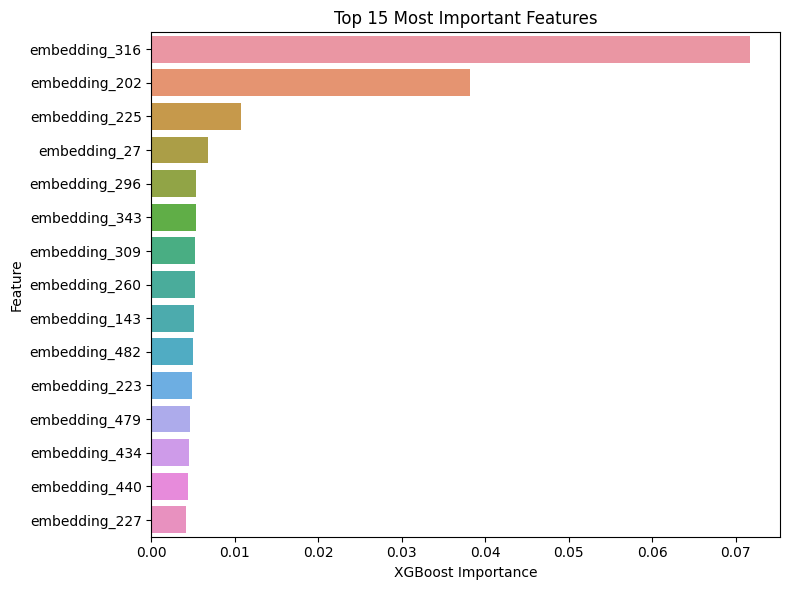

In [87]:
# ====================================================
# Evaluate Model Performance + Feature Importance
# ====================================================
y_pred = xgb.predict(X_val)

f1 = f1_score(y_val, y_pred)
print(f"\n F1 Score (with engineered features): {f1:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_val, y_pred))

# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot only top 15 for clarity
plt.figure(figsize=(8,6))
sns.barplot(y="Feature", x="Importance", data=importance_df.head(15))
plt.title("Top 15 Most Important Features")
plt.xlabel("XGBoost Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 12. Save final model and feature map

In [77]:
# ====================================================
# Save Final Model + Feature Map
# ====================================================
import joblib

joblib.dump(xgb, "/kaggle/working/xgb_mednlp_features.joblib")
train_feats.to_csv("/kaggle/working/train_features.csv", index=False)

print("Model and engineered features saved.")


✅ Model and engineered features saved.


# SUBMIT

In [ ]:
#last training
trainF_embeddings = model.encode(
    df['medical_note'].astype(str).tolist(),
    batch_size=16,
    show_progress_bar=True,
    device='cuda'
)

trainF_feats = df['medical_note'].astype(str).apply(extract_medical_features)
trainF_extra = trainF_feats.values

X_trainF = np.hstack([trainF_embeddings, trainF_extra])
y_trainF = df['has_diabetes'].values
xgb.fit(X_trainF, y_trainF)
print("XGBoost retrained with new features and all training data.")


Batches:   0%|          | 0/188 [00:00<?, ?it/s]

In [82]:
#Submision file will be done with test dataset
print("Generando embeddings para el conjunto de test...")
df_test = pd.read_csv("/kaggle/working/diabetes_test_data.csv")

test_embeddings = model.encode(
    df_test['medical_note'].astype(str).tolist(),
    batch_size=16,
    show_progress_bar=True,
    device='cuda'
)

test_feats = df_test['medical_note'].astype(str).apply(extract_medical_features)
test_extra = test_feats.values

X_test = np.hstack([test_embeddings, test_extra])

# Hacer predicciones con el modelo XGBoost
print("🔹 Realizando predicciones...")
y_pred = xgb.predict(X_test)

# Crear DataFrame con resultados
submission = pd.DataFrame({
    "patient_id": "patient_" + df_test["patient_id"].astype(str).str.zfill(5),
    "has_diabetes": y_pred
})

# Guardar como submission.csv
submission.to_csv("submission.csv", index=False)

print("Archivo 'submission.csv' generado correctamente.")
print(submission.head())

Generando embeddings para el conjunto de test...


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

🔹 Realizando predicciones...
Archivo 'submission.csv' generado correctamente.
      patient_id  has_diabetes
0  patient_37551             0
1  patient_24430             0
2  patient_89346             0
3  patient_88818             0
4  patient_00139             0
